In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.3.0


# 데이터셋 만들기

In [2]:
image_datas = glob('Train\\Normal\\*.jpg')+glob('Train\\glaucomatous\\*.jpg')+glob('Train\\diabetic_retinopathy\\*.jpg')+glob('Train\\cataract\\*.jpg')+glob('Train\\Background_Diabetic_Retinopathy\\*.jpg')+glob('Train\\Diabetic_Macular_Edema\\*.jpg')+glob('Train\\Choroidal_Neovascularization\\*.jpg')
forders = ['Normal', 'glaucomatous','diabetic_retinopathy']
class_name = [forder for forder in forders if not '.' in forder]
dic = {"Normal" : 0,
      "glaucomatous":1,
      "diabetic_retinopathy":2,
       "Diabetic_Macular_Edema":3,
       "cataract" : 4,
       "Background_Diabetic_Retinopathy" : 5,
       "Choroidal_Neovascularization" : 6
      }

In [31]:
class_name = []
class_name.append("Normal")
class_name.append("glaucomatous")
class_name.append("diabetic_retinopathy")
class_name.append("Diabetic_Macular_Edema")
class_name.append("cataract")
class_name.append("Background_Diabetic_Retinopathy")
class_name.append("Choroidal_Neovascularization")

In [32]:
from collections import defaultdict

In [33]:
def invert_dictionary(obj):
    inv_obj = defaultdict(list)
    for key, value in obj.items():
        inv_obj[value].append(key)
    return dict(inv_obj)
new_dic = invert_dictionary(dic)

In [35]:

for i in range(7):
    new_dic[i] = ''.join(new_dic[i])
new_dic

{0: 'Normal',
 1: 'glaucomatous',
 2: 'diabetic_retinopathy',
 3: 'Diabetic_Macular_Edema',
 4: 'cataract',
 5: 'Background_Diabetic_Retinopathy',
 6: 'Choroidal_Neovascularization'}

In [3]:
X = []
Y = []
for imagename in image_datas:
    image = Image.open(imagename)
    image = image.resize((128,128))
    image = np.array(image)
    X.append(image)
    label = imagename.split('\\')[1]
    label = dic[label]
    Y.append(label)

In [4]:
X = np.array(X)
Y = np.array(Y)


# 데이터셋 분리

In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size = 0.2, shuffle=True, random_state=44)

N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]
train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels [..., tf.newaxis]
# tf.newaxis : 새로운 차원을 추가하여, 다른 모양의 배열간 브로드 캐스팅을 가능하게 함

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((2670, 128, 128, 3), (2670, 1), (668, 128, 128, 3), (668, 1))

In [6]:
## train set의 각 class별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (2670)), axis =-1, return_counts=True)
dict(zip(unique, counts))

{0: 1356, 1: 415, 2: 591, 3: 126, 4: 83, 5: 51, 6: 48}

In [7]:
## test set의 각 class별 image수 확인
unique, counts = np.unique(np.reshape(test_labels, (668)), axis =-1, return_counts=True)
dict(zip(unique, counts))

{0: 346, 1: 97, 2: 151, 3: 25, 4: 17, 5: 19, 6: 13}

IndexError: list index out of range

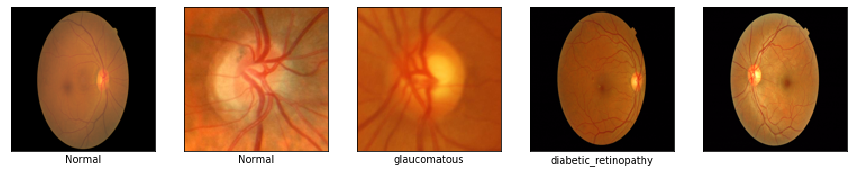

In [8]:
## Data확인
plt.figure(figsize = (15,9))
for i in range(15):
    img_idx = np.random.randint(0, N_TRAIN)
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_name[train_labels[img_idx][0]])

In [9]:
## pixel값을 0~1 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels, 7)
test_labels = keras.utils.to_categorical(test_labels, 7)

In [10]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(2670, 128, 128, 3) (2670, 7)
(668, 128, 128, 3) (668, 7)


In [11]:
train_images.shape[0]+test_images.shape[0]

3338

In [12]:
## Hyper parameters

IMG_CHANNERS = 3
IMG_ROWS = 128
IMG_COLS = 128

learning_rate = 0.01
EPOCHS = 10
BATCH_SIZE = 50
CLASS = 7
steps_per_epoch = N_TRAIN//BATCH_SIZE
validation_steps = N_TEST//BATCH_SIZE
OPTIM = tf.keras.optimizers.RMSprop()

In [13]:
## dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
buffer_size = 2701).batch(BATCH_SIZE).repeat()

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

#  모델 구성


In [15]:
# CONVNET 정의
def build(input_shape, classes):
    model = models.Sequential()
    model.add(keras.layers.Conv2D(filters = 32, kernel_size = 3,
                                 activation = 'relu', padding = 'SAME',
                                 input_shape = input_shape))
    model.add(keras.layers.MaxPool2D(padding = 'SAME'))
    model.add(keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                 activation = 'relu', padding = 'SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters = 128, kernel_size = 3,
                                 activation = 'relu', padding = 'SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(classes, activation='softmax'))
    return model

In [16]:
## 모델 생성. compile and summary
model = build((IMG_ROWS, IMG_COLS, IMG_CHANNERS), CLASS)
model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

In [17]:
## parameters for training
steps_per_epoch = N_TRAIN//BATCH_SIZE
validation_steps = N_TEST//BATCH_SIZE
print(steps_per_epoch, validation_steps)

53 13


In [18]:
# 텐서보드 사용
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs_Simple_Dataset')
]

In [19]:
## Training

model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch = steps_per_epoch, validation_data = test_dataset, validation_steps = validation_steps, callbacks = callbacks)

Epoch 1/10
 1/53 [..............................] - ETA: 0s - loss: 1.9184 - accuracy: 0.2800WARNING:tensorflow:From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
53/53 [==============================] - 37s 696ms/step - loss: 4.1820 - accuracy: 0.5185 - val_loss: 1.0130 - val_accuracy: 0.6062
Epoch 2/10
53/53 [==============================] - 37s 700ms/step - loss: 1.1113 - accuracy: 0.5496 - val_loss: 0.9755 - val_accuracy: 0.5923
Epoch 3/10
53/53 [==============================] - 35s 669ms/step - loss: 1.0560 - accuracy: 0.5615 - val_loss: 0.9545 - val_accuracy: 0.5862
Epoch 4/10
53/53 [==============================] - 37s 696ms/step - loss: 1.0302 - accuracy: 0.5565 - val_loss: 0.9085 - val_accuracy: 0.6385
Epoch 5/10
53/53 [==============================] - 37s 700ms/st

In [20]:
socre = model.evaluate(test_dataset)
print('\nTest Score : ',socre[0])
print('Test Accuracy : ',socre[1])

14/14 [==============================] - 2s 166ms/step - loss: 0.7634 - accuracy: 0.6557

Test Score :  0.7633746266365051
Test Accuracy :  0.6556886434555054


In [21]:
from sklearn.metrics import classification_report
import numpy as np
Y_test = np.argmax(test_labels, axis=1)
y_pred = model.predict_classes(test_dataset)
result = classification_report(Y_test, y_pred)

print(result)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.64      0.89      0.75       346
           1       0.82      0.78      0.80        97
           2       0.56      0.25      0.34       151
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        17
           5       0.59      0.53      0.56        19
           6       0.54      0.54      0.54        13

    accuracy                           0.66       668
   macro avg       0.45      0.43      0.43       668
weighted avg       0.61      0.66      0.61       668



C:\Users\YeoJunChoi\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                        100*np.max(predictions_array),
                                        class_name[true_label]),
                                        color = color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(CLASS), class_name, rotation=90)
    plt.yticks([])
    
    thisplot = plt.bar(range(CLASS), predictions_array, color='#777777')
    plt.ylim([0,1])

    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


In [23]:
def abc(i, array):
    a = array[i]
    df = pd.DataFrame(a)
    return df

In [25]:
import pandas as pd

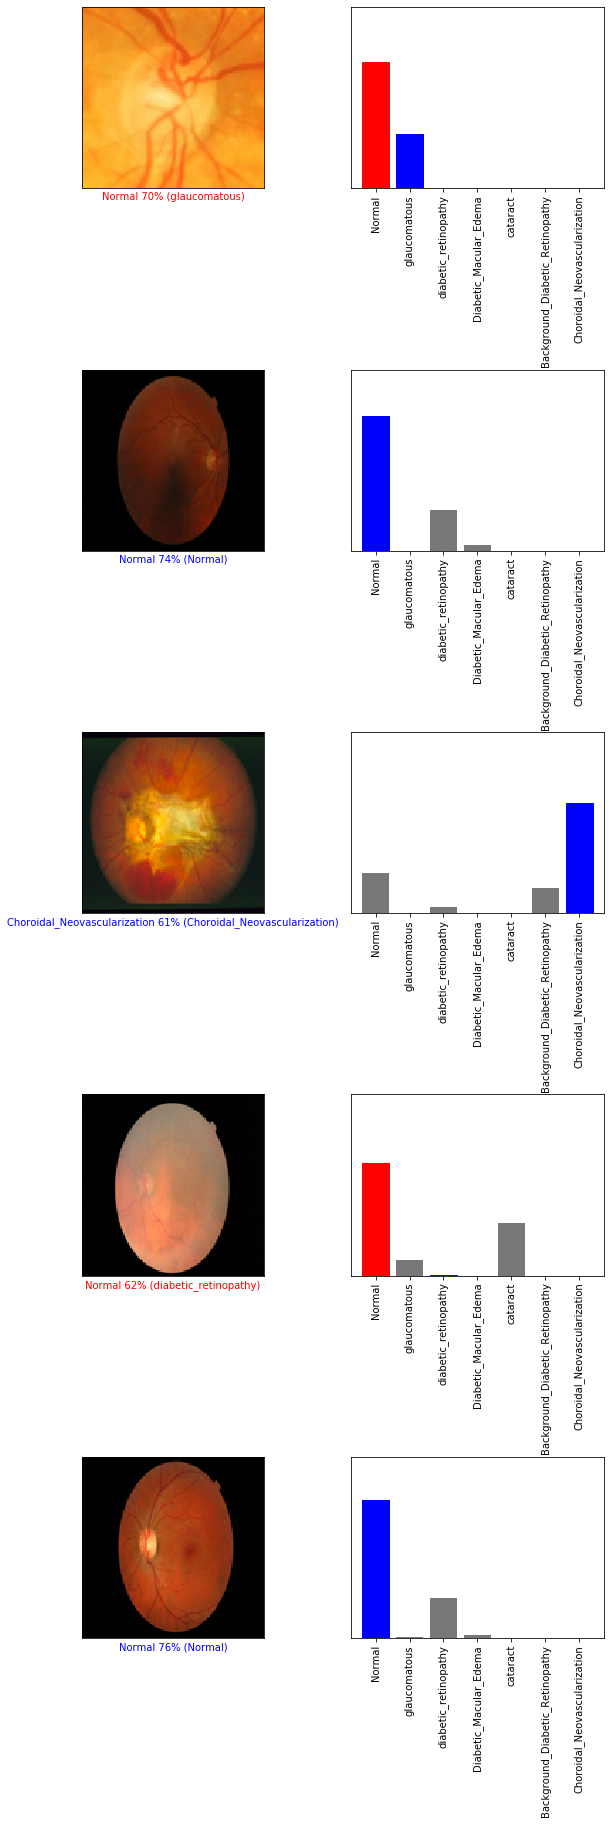

In [51]:
rnd_idx = np.random.randint(1, N_TEST//BATCH_SIZE)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt +=1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 1
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    
    plt.figure(figsize = (10,  30))
    plt.subplots_adjust(hspace=1.0)
    
    a = []
    
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i,predictions.numpy(), labels.numpy())
        df = abc(i,predictions.numpy())
        df = df[0].sort_values(ascending = False)
        a.append(df.head())
    break

In [52]:
for i in range(5):
    a[i] = a[i].rename(index=new_dic)

In [48]:
a[0].index.tolist()

['Normal',
 'diabetic_retinopathy',
 'Diabetic_Macular_Edema',
 'glaucomatous',
 'cataract']

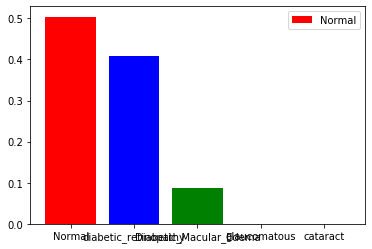

In [49]:
import matplotlib.pyplot as plt
plt.bar(a[1].index.tolist(),a[1],color = ['red','blue','green','yellow','black'])
plt.legend(a[1].index.tolist())

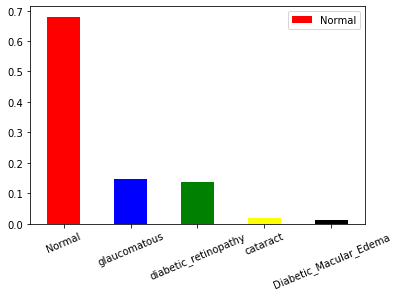

In [50]:
ax = a[3].plot(kind="bar", color = ['red','blue','green','yellow','black'], rot = 23)
ax.legend(labels=a[3].index.tolist())